In [1]:
%load_ext autoreload
%autoreload 2
%cd ..

/Users/gimli/projects/igre


In [39]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import os
from src.models.ig import information_gain as ig
import scipy.signal as sig

In [2]:
def cvtData(line):
    data = line.strip().split(" ")
    while '' in data:
        data.remove('')
    return data

with open("/Users/gimli/Qsync/datasets/Gent-Altairpiece/lamb/LamGods_Adoration_Lamb.ims", "r") as imsfile:
    line = imsfile.readline()
    version = cvtData(line)[0]
    
    line = imsfile.readline()
    [width, height, depth] = cvtData(line)
    
    print("expected dimensions:", width, height, depth)
    
    matrix = np.zeros((int(width), int(height), int(depth)))

    all_data = []
    line = imsfile.readline()
    while line:
        all_data.extend(cvtData(line))
        try:
            line = imsfile.readline()
        except Exception as e:
            print(len(all_data))

expected dimensions: 134 126 227
3832386


In [3]:
imgs = np.asarray(all_data[:3815784]).reshape(226, 126,134)

In [7]:
# This legend is from Steven's excel

legend = [["scaling", "Hydrocerussite", "2PbCO3.Pb(OH)2", "775,63"],
["weightf", "Hydrocerussite", "2PbCO3.Pb(OH)2", "775,63"],
["scaling", "Cerussite", "PbCO3", "267,21"],
["weightf", "Cerussite", "PbCO3", "267,21"],
["scaling", "Lead tin yellow", "Pb2SnO4", "597,11"],
["weightf", "Lead tin yellow", "Pb2SnO4", "597,11"],
["scaling", "Cinnabar", "HgS", "232,67"],
["weightf", "Cinnabar", "HgS", "232,67"],
["scaling", "Calcite", "CaCO3", "100,09"],
["weightf", "Calcite", "CaCO3", "100,09"],
["scaling", "Posnjakite", "Cu4(SO4)(OH)6 · H2O", "470,31"],
["weightf", "Posnjakite", "Cu4(SO4)(OH)6 · H2O", "470,31"],
["scaling", "Gold", "Au", "196,97"],
["weightf", "Gold", "Au", "196,97"],
["scaling", "Zincite", "ZnO", "81,38"],
["weightf", "Zincite", "ZnO", "81,38"],
["scaling", "Goethite", "FeO(OH)", "88,85"],
["weightf", "Goethite", "FeO(OH)", "88,85"]]

In [8]:
# This bands were selected by Steven as relevant for the Lamb
lamb = imgs[[1, 2, 22, 23, 45, 46, 67, 68, 89, 90, 111, 112, 133, 134, 155, 156, 177, 178],:,:].astype(float);

In [20]:
# Creation of hypercube
xrpd = cv2.flip(lamb, flipCode=1)
xrpd = np.moveaxis(xrpd, 0, 2)

In [41]:
## Load registered data from Michal
xrf_folder='/Users/gimli/Qsync/datasets/Gent-Altairpiece/lamb/registered-downsample'
files = os.listdir(xrf_folder)
xrf = np.zeros((xrpd.shape[0], xrpd.shape[1], len(files)))
for idx, file in enumerate(files):
    xrf[:,:, idx] = cv2.cvtColor(cv2.imread(os.path.join(xrf_folder, file)),cv2.COLOR_BGR2GRAY)/255.0

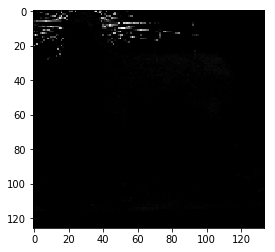

In [42]:
plt.imshow(xrf[:,:,14], cmap="gray")
plt.show()

In [56]:
pd_avg = np.mean(xrpd.reshape((xrpd.shape[0] * xrpd.shape[1], xrpd.shape[2])), axis=0)
pd_std = np.std(xrpd.reshape((xrpd.shape[0] * xrpd.shape[1], xrpd.shape[2])), axis=0)
f_avg = np.mean(xrf.reshape((xrf.shape[0] * xrf.shape[1], xrf.shape[2])), axis=0)
f_std = np.std(xrf.reshape((xrf.shape[0] * xrf.shape[1], xrf.shape[2])), axis=0)

In [60]:
pd_norm = np.zeros(xrpd.shape)
for dim in range(pd_avg.shape[0]):
    pd_norm[:,:,dim] = (xrpd[:,:,dim] - pd_avg[dim]) / pd_std[dim]

In [75]:
f_norm = np.zeros(xrf.shape)
for dim in range(f_avg.shape[0]):
    f_norm[:,:,dim] = (xrf[:,:,dim] - f_avg[dim]) / f_std[dim]

In [526]:
[gain, approx, net] = ig(f_norm[:115,:,[9,10]], pd_norm[:115,:,[1,3,5]], layers=[100,100,100,100])

Selecting 25000 samples randomly for use by algorithm.
Adding input layer, width = 2
Adding dense layer, width = 100
Adding dense layer, width = 100
Adding dense layer, width = 100
Adding dense layer, width = 100
Adding dense layer, width = 3
Compiling model took 0.5256's.
Train on 12328 samples, validate on 3082 samples
Epoch 1/40
12328/12328 [==============================] - 4s 328us/sample - loss: 0.7095 - mean_squared_error: 0.7095 - val_loss: 0.4907 - val_mean_squared_error: 0.4907
Epoch 2/40
12328/12328 [==============================] - 2s 149us/sample - loss: 0.4506 - mean_squared_error: 0.4506 - val_loss: 0.4296 - val_mean_squared_error: 0.4296
Epoch 3/40
12328/12328 [==============================] - 2s 141us/sample - loss: 0.4044 - mean_squared_error: 0.4044 - val_loss: 0.4158 - val_mean_squared_error: 0.4158
Epoch 4/40
12328/12328 [==============================] - 2s 157us/sample - loss: 0.4000 - mean_squared_error: 0.4000 - val_loss: 0.4274 - val_mean_squared_error: 0.42

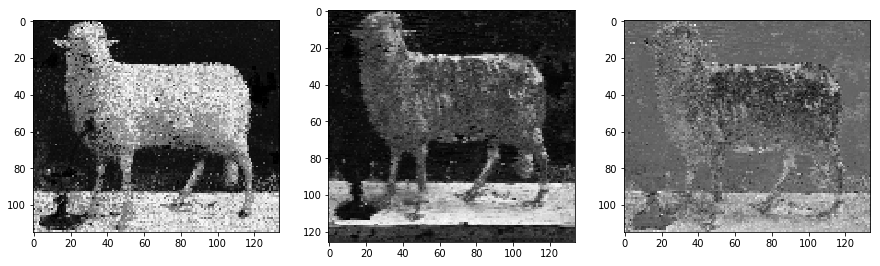

In [527]:
plt.figure(figsize=(15,5))
ax = plt.subplot(1,3,1)
ax.imshow(approx[:,:,0], cmap="gray")
ax = plt.subplot(1,3,2)
ax.imshow(pd_norm[:,:,1], cmap="gray")
ax = plt.subplot(1,3,3)
ax.imshow(gain[:,:,0], cmap="gray")
plt.show()

In [314]:
f_med = np.zeros(f_norm.shape)
for dim in range(f_med.shape[2]):
    f_med[:,:,dim] = sig.medfilt(f_norm[:,:,dim], kernel_size=5)

In [308]:
pd_med = np.zeros(pd_norm.shape)
for dim in range(pd_med.shape[2]):
    pd_med[:,:,dim] = sig.medfilt(pd_norm[:,:,dim], kernel_size=7)

In [376]:
[gain, approx, net] = ig(f_med[:115,:,[9, 10]], pd_med[:115,:,[1,3,5]], layers=[100,100,100])

Selecting 25000 samples randomly for use by algorithm.
Adding input layer, width = 2
Adding dense layer, width = 100
Adding dense layer, width = 100
Adding dense layer, width = 100
Adding dense layer, width = 3
Compiling model took 0.6698's.
Train on 12328 samples, validate on 3082 samples
Epoch 1/40
12328/12328 [==============================] - 3s 280us/sample - loss: 0.5277 - mean_squared_error: 0.5277 - val_loss: 0.3595 - val_mean_squared_error: 0.3595
Epoch 2/40
12328/12328 [==============================] - 2s 152us/sample - loss: 0.3515 - mean_squared_error: 0.3515 - val_loss: 0.3245 - val_mean_squared_error: 0.3245
Epoch 3/40
12328/12328 [==============================] - 2s 152us/sample - loss: 0.3320 - mean_squared_error: 0.3320 - val_loss: 0.3077 - val_mean_squared_error: 0.3077
Epoch 4/40
12328/12328 [==============================] - 2s 156us/sample - loss: 0.3020 - mean_squared_error: 0.3020 - val_loss: 0.2711 - val_mean_squared_error: 0.2711
Epoch 5/40
12328/12328 [=====

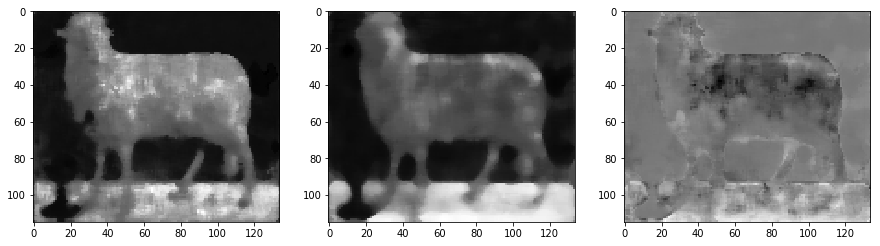

In [377]:
plt.figure(figsize=(15,5))
ax = plt.subplot(1,3,1)
ax.imshow(approx[:,:,0], cmap="gray")
ax = plt.subplot(1,3,2)
ax.imshow(pd_med[:115,:,1], cmap="gray")
ax = plt.subplot(1,3,3)
ax.imshow(gain[:,:,0], cmap="gray")
plt.show()

In [378]:
pd_predict = diff.predict(f_norm[:115,:,[9,10]].reshape((115*134,2))).reshape(115,134,3)

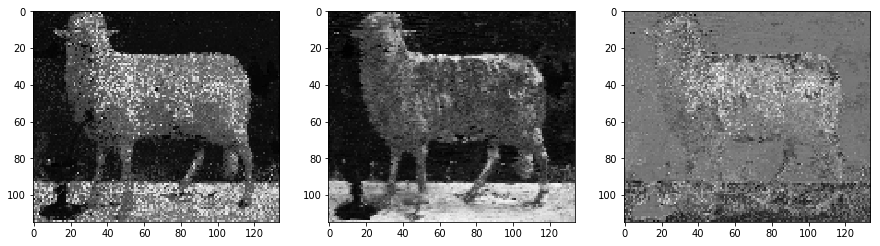

In [385]:
plt.figure(figsize=(15,5))
ax = plt.subplot(1,3,1)
ax.imshow(pd_predict[:,:,0], cmap="gray")
ax = plt.subplot(1,3,2)
ax.imshow(pd_norm[:115,:,1], cmap="gray")
ax = plt.subplot(1,3,3)
ax.imshow(pd_predict[:,:,0]-pd_norm[:115,:,1], cmap="gray")
plt.show()

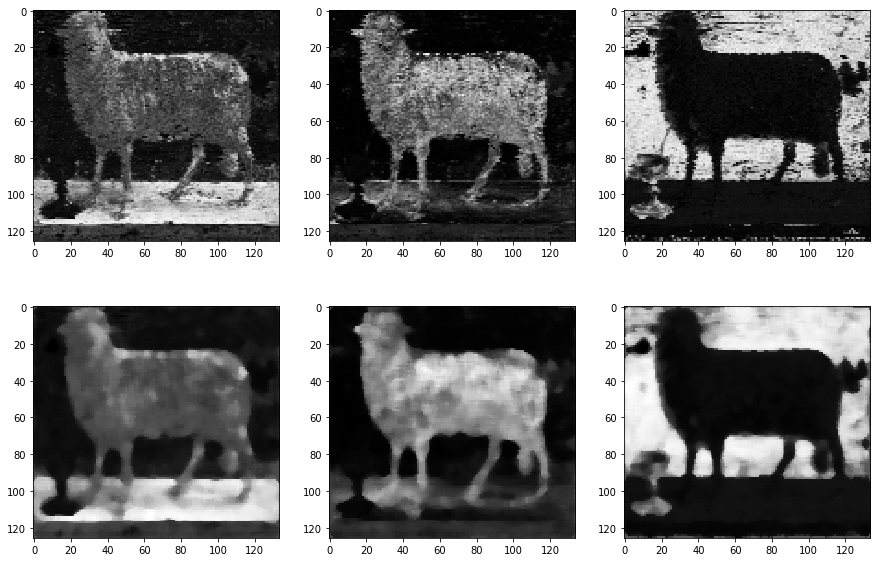

In [205]:
# Normalized XRPD - HC, C, LT
plt.figure(figsize=(15,10))
ax = plt.subplot(2,3,1)
ax.imshow(pd_norm[:,:,1], cmap="gray")
ax = plt.subplot(2,3,2)
ax.imshow(pd_norm[:,:,3], cmap="gray")
ax = plt.subplot(2,3,3)
ax.imshow(pd_norm[:,:,5], cmap="gray")
# Median filtered (the same)
ax = plt.subplot(2,3,4)
ax.imshow(pd_med[:,:,1], cmap="gray")
ax = plt.subplot(2,3,5)
ax.imshow(pd_med[:,:,3], cmap="gray")
ax = plt.subplot(2,3,6)
ax.imshow(pd_med[:,:,5], cmap="gray")
plt.show()

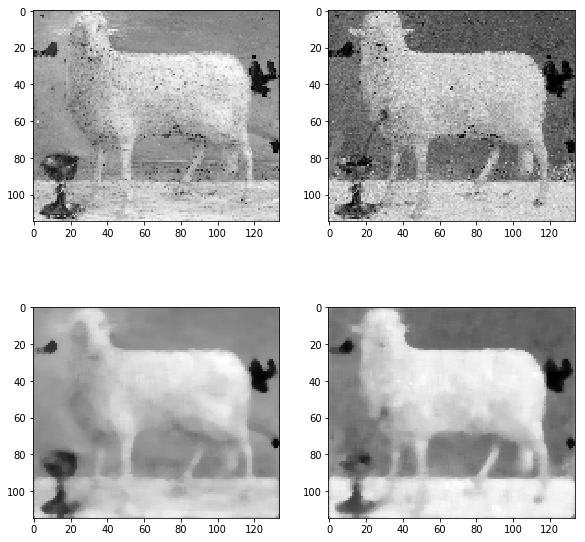

In [202]:
# Normalized XRF - PbL, PbM
plt.figure(figsize=(15,10))
ax = plt.subplot(2,3,1)
ax.imshow(f_norm[:115,:,9], cmap="gray")
ax = plt.subplot(2,3,2)
ax.imshow(f_norm[:115,:,10], cmap="gray")
ax = plt.subplot(2,3,4)
ax.imshow(f_med[:115,:,9], cmap="gray")
ax = plt.subplot(2,3,5)
ax.imshow(f_med[:115,:,10], cmap="gray")
plt.show()

In [215]:
[coef, residua, _, _] = np.linalg.lstsq(pd_med[:115, :, 1].reshape((115*134,1)), 
                                        f_med[:115, :, [9,10]].reshape((115*134, 2)),rcond=None)

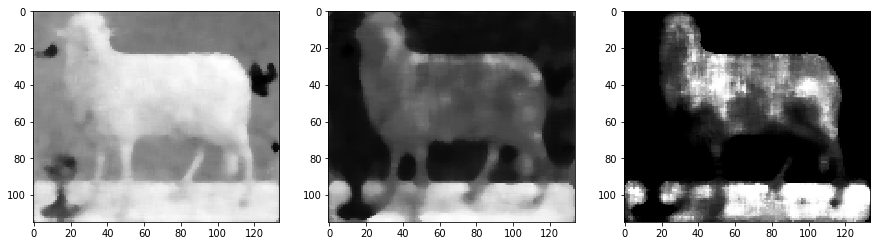

In [332]:
plt.figure(figsize=(15,5))
ax = plt.subplot(1,3,1)
ax.imshow((f_med[:115, :, [9]] * coef[0][0] + f_med[:115, :, [10]] * coef[0][1]).reshape(115,134), cmap="gray")
ax = plt.subplot(1,3,2)
ax.imshow(pd_med[:115, :, 1], cmap="gray")
ax = plt.subplot(1,3,3)
ax.imshow(approx[:,:,1], cmap="gray")
plt.show()

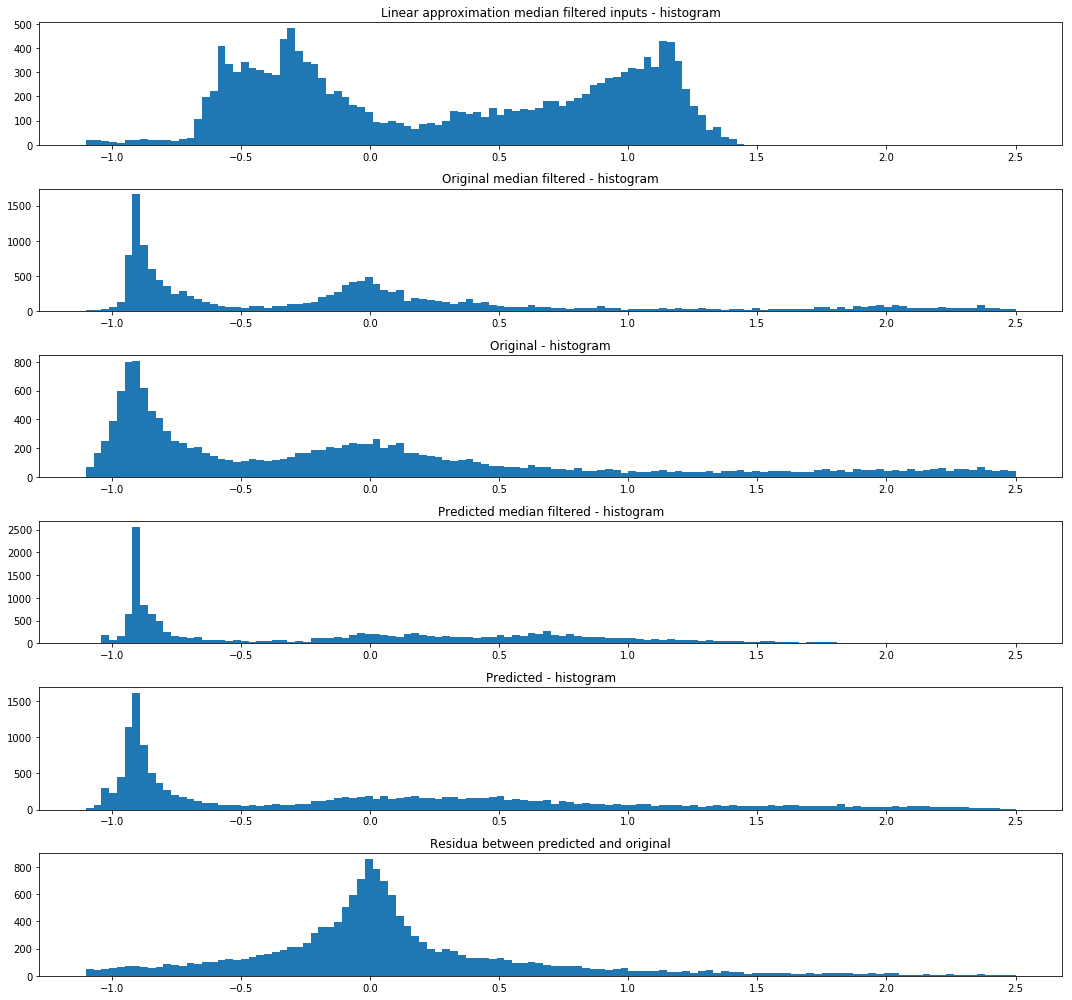

In [504]:
plt.figure(figsize=(15,14))
ax = plt.subplot(6,1,1)
ax.set_title("Linear approximation median filtered inputs - histogram")
ax.hist((f_med[:115, :, [9]] * coef[0][0] + f_med[:115, :, [10]] * coef[0][1]).reshape(115*134),  bins=np.arange(-1.1,2.5,0.03))
ax = plt.subplot(6,1,2)
ax.set_title("Original median filtered - histogram")
ax.hist(pd_med[:115, :, 1].reshape(115*134), bins=np.arange(-1.1,2.5,0.03))
ax = plt.subplot(6,1,3)
ax.set_title("Original - histogram")
ax.hist(pd_norm[:115, :, 1].reshape(115*134), bins=np.arange(-1.1,2.5,0.03))
ax = plt.subplot(6,1,4)
ax.set_title("Predicted median filtered - histogram")
ax.hist(approx[:,:,0].reshape(115*134), bins=np.arange(-1.1,2.5,0.03))
ax = plt.subplot(6,1,5)
ax.set_title("Predicted - histogram")
ax.hist(pd_predict[:,:,0].reshape(115*134), bins=np.arange(-1.1,2.5,0.03))
ax = plt.subplot(6,1,6)
ax.set_title("Residua between predicted and original")
ax.hist((pd_predict[:,:,0]-pd_norm[:115,:,1]).reshape(115*134), bins=np.arange(-1.1,2.5,0.03))
plt.tight_layout()
plt.show()

In [288]:
np.set_printoptions(2)

In [390]:
np.corrcoef(np.moveaxis(
            np.concatenate([f_norm[:115, :, 9].reshape((115*134,1)),
                            f_norm[:115, :, 10].reshape((115*134,1)),
                            pd_med[:115, :, 1].reshape((115*134,1)),
                            pd_norm[:115, :, 1].reshape((115*134,1)),
                            (f_med[:115, :, [9]] * coef[0][0] + f_med[:115, :, [10]] * coef[0][1]).reshape((115*134,1)),
                            approx[:,:,0].reshape((115*134,1))
                           ], axis=1),
    0, 1
))

array([[1.  , 0.83, 0.61, 0.62, 0.86, 0.72],
       [0.83, 1.  , 0.75, 0.75, 0.92, 0.88],
       [0.61, 0.75, 1.  , 0.93, 0.78, 0.86],
       [0.62, 0.75, 0.93, 1.  , 0.74, 0.81],
       [0.86, 0.92, 0.78, 0.74, 1.  , 0.92],
       [0.72, 0.88, 0.86, 0.81, 0.92, 1.  ]])

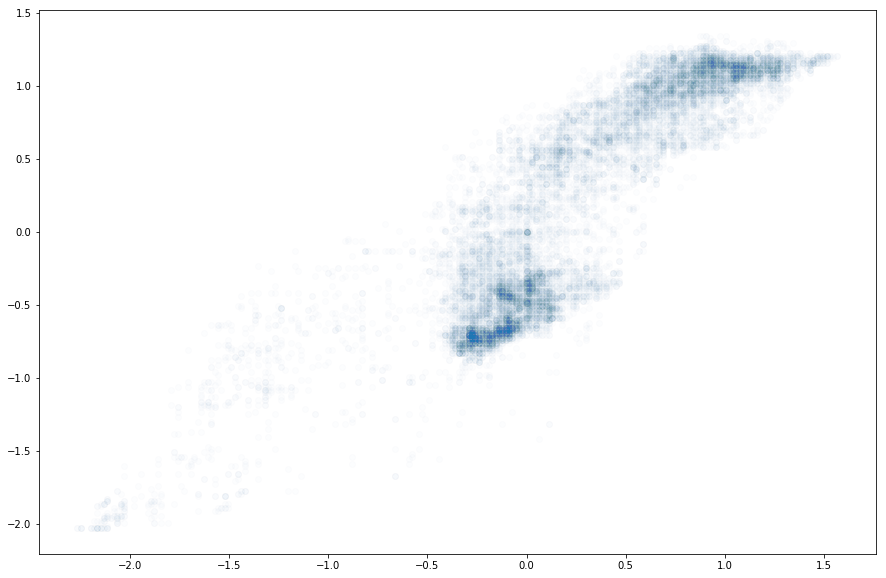

In [394]:
plt.figure(figsize=(15,10))
plt.scatter(f_med[:115, :, [9]].reshape((115*134, 1)), f_med[:115, :, [10]].reshape((115*134, 1)), alpha=0.01)
plt.show()

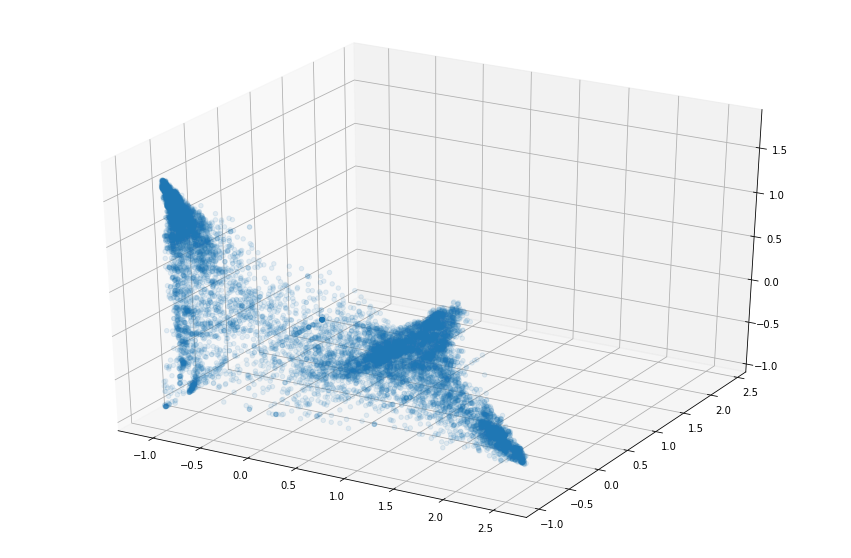

In [391]:
from mpl_toolkits.mplot3d import Axes3D
fig = plt.figure(figsize=(15,10))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(pd_med[:115, :, [1]].reshape((115*134, 1)), 
           pd_med[:115, :, [3]].reshape((115*134, 1)), 
           pd_med[:115, :, [5]].reshape((115*134, 1)), alpha=0.1)
plt.show()

In [444]:
Tij = [[0.1665, -3.8000e-05, -17.4220],[-4.8909e-04, 0.1787, -63.3877],[0,0,1]]

In [457]:
Tcv2 = np.float32(np.linalg.inv(Tij)[:2,:])

In [465]:
pbxrf=np.zeros((1000,1000,2))
pbxrf[:,:,0] = cv2.imread('/Users/gimli/Qsync/datasets/Gent-Altairpiece/lamb/xrf/PbL.png')[:,:,0]
pbxrf[:,:,1] = cv2.imread('/Users/gimli/Qsync/datasets/Gent-Altairpiece/lamb/xrf/PbM.png')[:,:,0]

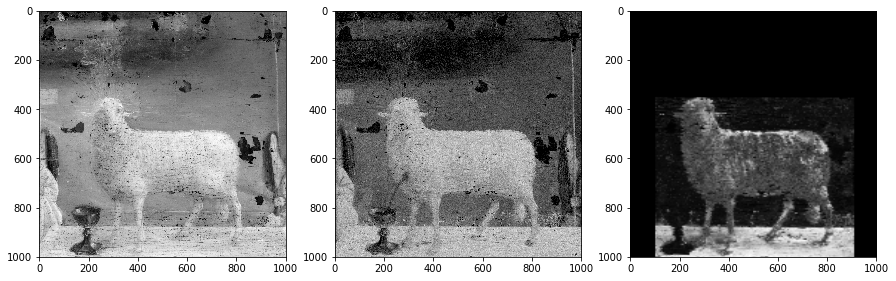

In [472]:
plt.figure(figsize=(15,5))
ax = plt.subplot(1,3,1)
ax.imshow(pbxrf[:,:,0], cmap="gray")
ax = plt.subplot(1,3,2)
ax.imshow(pbxrf[:,:,1], cmap="gray")
ax = plt.subplot(1,3,3)
ax.imshow(cv2.warpAffine(xrpd[:,:,1], Tcv2, (1000,1000)), cmap="gray")
plt.show()

In [528]:
pbxrf_norm = np.zeros(pbxrf.shape)
for dim in range(pbxrf.shape[2]):
    pbxrf_norm[:,:,dim] = (pbxrf[:,:,dim] - np.mean(pbxrf[:,:,dim])) / np.std(pbxrf[:,:,dim])
pd_up = net.predict(pbxrf_norm.reshape(1000*1000,2)).reshape(1000,1000,3)
# This way we preserve intensity in images.
# One value on the otherside does not have any statistical relevance (but must be ignored in evaluations).
pd_up[0,0,0] = np.min(pd_norm[:,:,1])
pd_up[-1,-1,0] = np.max(pd_norm[:,:,1])

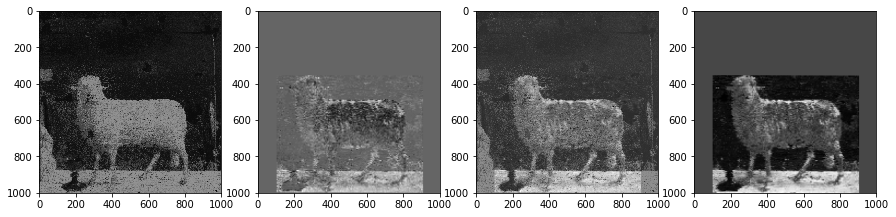

In [529]:
plt.figure(figsize=(15,5))
ax = plt.subplot(1,4,1)
ax.imshow(pd_up[:,:,0], cmap="gray")
ax = plt.subplot(1,4,2)
ax.imshow(cv2.warpAffine(gain[:,:,0], Tcv2, (1000,1000)), cmap="gray")
ax = plt.subplot(1,4,3)
ax.imshow(pd_up[:,:,0] + cv2.warpAffine(gain[:,:,0], Tcv2, (1000,1000)), cmap="gray")
ax = plt.subplot(1,4,4)
ax.imshow(cv2.warpAffine(pd_norm[:,:,1], Tcv2, (1000,1000)), cmap="gray")
plt.show()

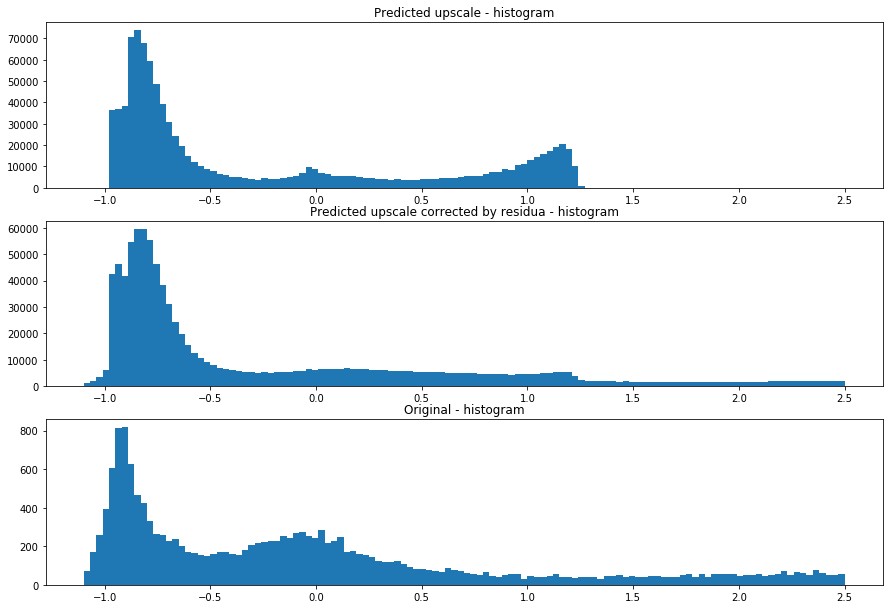

In [530]:
plt.figure(figsize=(15,14))
ax = plt.subplot(4,1,1)
ax.set_title("Predicted upscale - histogram")
ax.hist(pd_up[:,:,0].reshape(1000*1000,1), bins=np.arange(-1.1,2.5,0.03))
ax = plt.subplot(4,1,2)
ax.set_title("Predicted upscale corrected by residua - histogram")
ax.hist((pd_up[:,:,0] + cv2.warpAffine(gain[:,:,0], Tcv2, (1000,1000))).reshape(1000*1000,1), bins=np.arange(-1.1,2.5,0.03))
ax = plt.subplot(4,1,3)
ax.set_title("Original - histogram")
ax.hist(pd_norm[:,:,1].reshape(pd_norm.shape[0]*pd_norm.shape[1],1), bins=np.arange(-1.1,2.5,0.03))
plt.show()

In [571]:
pd_up_denorm = (pd_up[:,:,2] + cv2.warpAffine(gain[:,:,2], Tcv2, (1000,1000))) * pd_std[5] + pd_avg[5]
pd_up_denorm[0,0] = np.min(xrpd[:,:,5])
pd_up_denorm [-1,-1] = np.max(xrpd[:,:,5])

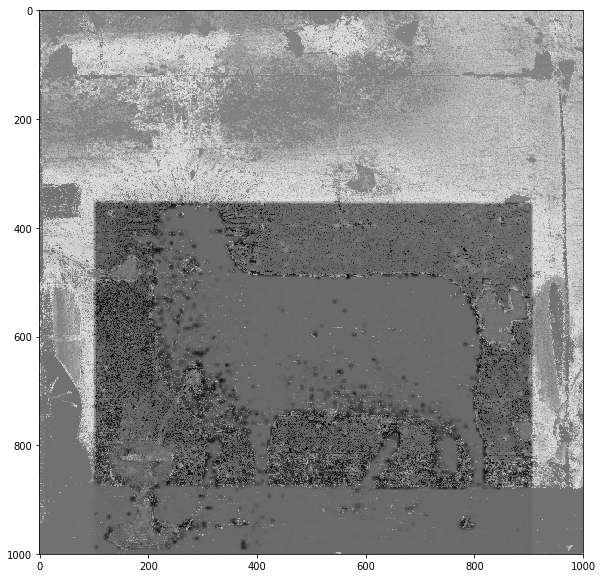

In [572]:
plt.figure(figsize=(10,10))
plt.imshow(
    pd_up_denorm - cv2.warpAffine(xrpd[:,:,5], Tcv2, (1000,1000)), 
    cmap="gray")
plt.show()

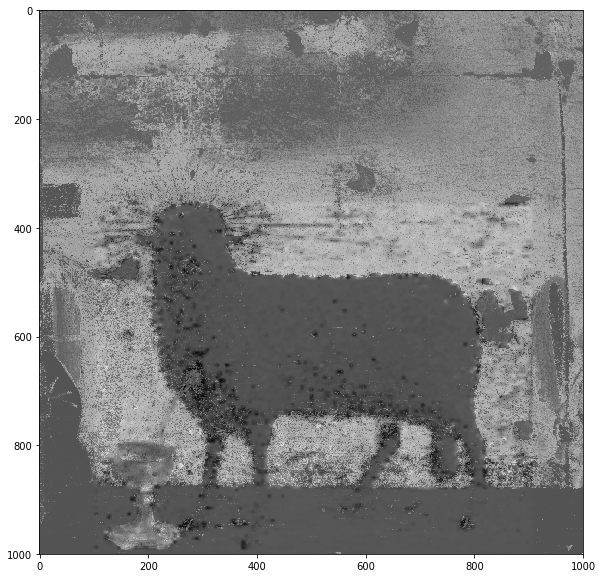

In [573]:
plt.figure(figsize=(10,10))
plt.imshow(pd_up_denorm, cmap="gray")
plt.show()

In [574]:
c_orig = cv2.warpAffine(xrpd[:,:,5], Tcv2, (1000,1000))
c_write = (c_orig - np.min(c_orig)) / (np.max(c_orig) - np.min(c_orig)) * 255

cv2.imwrite('/Users/gimli/Qsync/datasets/Gent-Altairpiece/lty.png', c_write)

True

In [575]:
cv2.imwrite('/Users/gimli/Qsync/datasets/Gent-Altairpiece/ltyup.png', 
            (pd_up_denorm - np.min(c_orig)) / (np.max(c_orig) - np.min(c_orig)) * 255)

True

In [570]:
pd_up.shape

(1000, 1000, 3)

In [562]:
np.max(imgs[23, :,:].astype(float))

2.68411e-06

In [553]:
imgs.shape

(226, 126, 134)